# Hyperparameter training for Base Matrix Factorisation

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error 

# load in the three datasets
data_Kd = DTI(name = 'BindingDB_Kd')
data_Kd.convert_to_log(form = 'binding')

data_ic50 = DTI(name = 'BindingDB_IC50')
data_ic50.convert_to_log(form = 'binding')

data_Ki = DTI(name = 'BindingDB_Ki')
data_Ki.convert_to_log(form = 'binding')

Found local copy...
Loading...
Done!
To log space...
Found local copy...
Loading...
Done!
To log space...
Found local copy...
Loading...
Done!
To log space...


In [2]:
data_Kd.get_data()

,Drug_ID,Drug,Target_ID,Target,Y
0,444607.0,Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.251812
1,4316.0,COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.229148
2,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.031517
3,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.522879
4,1612.0,COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.585027
...,...,...,...,...,...
52269,53358942.0,COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,9.602060
52270,53476877.0,CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2CC[C@H](O)...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,8.552842
52271,58573469.0,CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,9.838632
52272,113557.0,CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,7.767004


## ALS model
Model used is adapted from https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74

In [3]:
def data_split(data):
    # split data and get ID dicts
    split = data.get_split(method = 'random', seed = 42, frac = [0.6, 0.05, 0.35])
    train = split['train']
    test = split['test']

    train = train[['Drug_ID', 'Target', 'Y']].dropna()

    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug_ID']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))

    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # load data into correct format
    data["Target_ID2"] = data["Target"].apply(lambda x:target_dict.get(x))
    data["Drug_ID2"] = data["Drug_ID"].apply(lambda x:drug_dict.get(x))
    data = data.dropna()

    drug_ID = data["Drug_ID2"].to_numpy()
    target_ID = data["Target_ID2"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label


class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)

In [4]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

In [5]:
# def train_model(train_loader, test_loader, model, num_epochs=10):
#     dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#     loss_func = torch.nn.MSELoss()
#     model.to(dev)
    
#     train_losses = []
#     test_losses = []
#     for epoch in range(0,num_epochs):
#         count = 0
#         cum_loss = 0.
#         for i, (train_batch, label_batch) in enumerate(train_loader):
#             count = 1 + i
#             # Predict and calculate loss for user factor and bias
#             optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
#             prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
#             loss = loss_func(prediction, label_batch.to(dev)).float()    
#             # Backpropagate
#             loss.backward()

#             # Update the parameters
#             optimizer.step()
#             optimizer.zero_grad()

#             #predict and calculate loss for item factor and bias
#             optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
#             prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
#             loss = loss_func(prediction, label_batch.to(dev))
#             loss_item = loss.item()
#             if loss_item > 0:
#                 cum_loss += loss_item
#             else:
#                 count -= 1

#             # Backpropagate
#             loss.backward()

#             # Update the parameters
#             optimizer.step()
#             optimizer.zero_grad()
#         train_loss = cum_loss/count
#         train_losses.append(train_loss)

#         cum_loss =0.
#         count = 0
#         for i, (test_batch, label_batch) in enumerate(test_loader):
#             count = 1 + i
#             with torch.no_grad():
#                 prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
#                 loss = loss_func(prediction, label_batch.to(dev))
#                 loss_item = loss.item()
#                 if loss_item > 0:
#                     cum_loss += loss_item
#                 else:
#                     count -= 1
                
#         test_loss = cum_loss/count
#         test_losses.append(test_loss)
#         if epoch % 24 == 0:
#             print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
#     return train_losses, test_losses, prediction


In [6]:
# def model(data, img_name, n_factors=100, bs=100, num_epochs=100):
#     train, test, drug_dict, target_dict = data_split(data)
#     x_train, y_train = data_loader(train, drug_dict, target_dict)
#     x_test, y_test = data_loader(test, drug_dict, target_dict)

#     train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
#     test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

#     model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors=n_factors)

#     train_losses, test_losses, preds_te = train_model(train_dataloader, test_dataloader, model, num_epochs)
    
#     epochs = range(1, num_epochs+1)
#     plt.plot(epochs, train_losses, label='train')
#     plt.plot(epochs, test_losses, label='test')
#     plt.xlabel('epoch')
#     plt.ylabel('mse loss')
#     plt.legend()
#     plt.title(img_name)
#     plt.savefig(img_name)
#     plt.show()
    
#     return train_losses, test_losses, preds_te

In [7]:
def train_model(train_loader, test_loader, model, num_epochs=10):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            #predict and calculate loss for item factor and bias
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            if loss_item > 0:
                cum_loss += loss_item
            else:
                count -= 1

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        test_pred_record  = []
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                loss_item = loss.item()
                if loss_item > 0:
                    cum_loss += loss_item
                else:
                    count -= 1
                
            test_pred_record.append(prediction.data)
                
                
        test_loss = cum_loss/count
        test_losses.append(test_loss)
        test_pred = torch.cat(test_pred_record)
        
        if epoch % 24 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses, test_pred


In [8]:
def model(data, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors=n_factors)

    train_losses, test_losses, preds_te = train_model(train_dataloader, test_dataloader, model, num_epochs)
    
    
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
    plt.savefig(img_name)
    plt.show()
    
    preds_test = preds_te.cpu().numpy()
    print('MAE:', mean_absolute_error(y_test,preds_test))
    print('MSE:', mean_squared_error(y_test,preds_test))

    return train_losses, test_losses, preds_test

## Kd Dataset

epoch:  0  avg training loss:  33.27620621699437  avg test loss:  28.065494319370814
epoch:  24  avg training loss:  7.657278914360484  avg test loss:  4.670711387906755
epoch:  48  avg training loss:  5.418553049397317  avg test loss:  3.3391931704112463
epoch:  72  avg training loss:  4.184713618770527  avg test loss:  2.6219454876014163
epoch:  96  avg training loss:  3.3839674273114295  avg test loss:  2.16434217606272


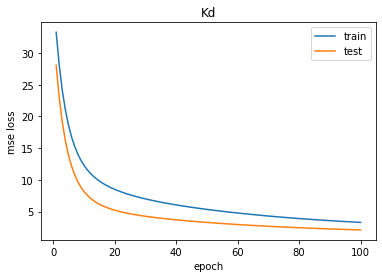

MAE: 0.8879491209819841
MSE: 2.120307170613062


In [9]:
train_losses_kd, test_losses_kd, prediction = model(data_Kd, 'Kd', bs=100, num_epochs=100)

## IC50 Dataset

epoch:  0  avg training loss:  29.898213557384075  avg test loss:  20.63785596890803
epoch:  24  avg training loss:  3.4014884248859185  avg test loss:  3.251790507083872
epoch:  48  avg training loss:  2.3887071113955654  avg test loss:  2.428611657869443
epoch:  72  avg training loss:  1.9904865814320076  avg test loss:  2.1052335692943056
epoch:  96  avg training loss:  1.7576081573123092  avg test loss:  1.921304508851833


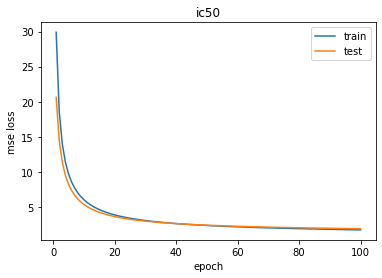

MAE: 1.0522048888848272
MSE: 1.9033970168281082


In [11]:
train_losses_ic50, test_losses_ic50, prediction_ic50 = model(data_ic50, 'ic50', n_factors=20, bs=100, num_epochs=100)

## Ki Dataset

epoch:  0  avg training loss:  35.98049329856818  avg test loss:  24.99689169794684
epoch:  24  avg training loss:  4.826385532976479  avg test loss:  4.320870063301675
epoch:  48  avg training loss:  3.2873255112158355  avg test loss:  3.1059873871938786
epoch:  72  avg training loss:  2.6328141439345574  avg test loss:  2.6007523449573853
epoch:  96  avg training loss:  2.199006733714893  avg test loss:  2.2897938496366406


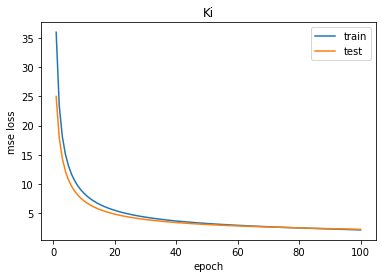

MAE: 1.1456267553361936
MSE: 2.257490137202597


In [12]:
train_losses_ki, test_losses_ki, prediction_ki = model(data_Ki, 'Ki', bs=100, num_epochs=100)

#### grid search

In [13]:
def train_model_hyp(train_loader, test_loader, model, num_epochs=10, lr=0.01, print_log = True):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=lr, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            #predict and calculate loss for item factor and bias
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=lr, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            if loss_item > 0:
                cum_loss += loss_item
            else:
                count -= 1

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        test_pred_record  = []
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                loss_item = loss.item()
                if loss_item > 0:
                    cum_loss += loss_item
                else:
                    count -= 1
            test_pred_record.append(prediction.data)
                
        test_loss = cum_loss/count
        test_losses.append(test_loss)
        test_pred = torch.cat(test_pred_record)
        
        if (epoch % 20 == 0)&print_log:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses, test_pred


In [14]:
def model_hyp(data, img_name, n_factors=100, bs=100, num_epochs=100, lr=0.01, print_log = True):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors=n_factors)

    train_losses, test_losses, preds_te = train_model_hyp(train_dataloader, test_dataloader, model, num_epochs, lr=lr, print_log = print_log)
    
    preds_test = preds_te.cpu().numpy()
    MAE_te = mean_absolute_error(y_test,preds_test)
    MSE_te = mean_squared_error(y_test,preds_test)
    print('MAE:', MAE_te)
    print('MSE:', MSE_te)
    
    return train_losses, test_losses , MAE_te, MSE_te


def plotting(train_losses, test_losses, train_tuned, test_tuned, title = ""):
    epochs = range(1, len(train_losses)+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, train_tuned, label='train_tuned')
    plt.plot(epochs, test_losses, label='test')
    plt.plot(epochs, test_tuned, label='test_tuned')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(title)
    plt.savefig(title)
    plt.show()

In [15]:
def grid_search(data, img_name, learning_rate=[], n_factors=[]):
        
    times = 0
    records = []
    MAE_records = []
    MSE_records = []
    for lr in learning_rate:
        for nf in n_factors:
            times += 1
            print("hyperparameters",times)
            print("The learning rate =",lr)
            print("Number of factors =",nf)
            
            train_tuned, test_tuned, MAE_test, MSE_test = model_hyp(data, img_name, n_factors=nf, bs=100, 
                                                                    num_epochs=100, lr=lr, print_log = False)
            record = {'learning_rate':lr, 'n_factors':nf}
            MAE_records.append(MAE_test)
            MSE_records.append(MSE_test)
            records.append(record)
    
    best_param_dict = records[MSE_records.index(min(MSE_records))]
    
#     train_tuned, test_tuned, MAE_test, MSE_test = model_hyp(data, img_name, n_factors=best_param_dict['n_factors'], 
#                                                             bs=100, num_epochs=100, lr=best_param_dict['learning_rate'])
#     plotting(train_losses, test_losses, train_tuned, test_tuned, title = img_name) 
    
    print("Done")
    return best_param_dict


## Kd Dataset

In [16]:
bestParamDict_kd = grid_search(data_Kd, 'Kd', learning_rate=[0.05,0.04,0.03], n_factors=[20,50,80])

hyperparameters 1
The learning rate = 0.05
Number of factors = 20
MAE: 0.5940586460222255
MSE: 0.9146625233900683
hyperparameters 2
The learning rate = 0.05
Number of factors = 50
MAE: 0.5919945244297432
MSE: 0.9282307629865992
hyperparameters 3
The learning rate = 0.05
Number of factors = 80
MAE: 0.5862734833419367
MSE: 0.9247558985344685
hyperparameters 4
The learning rate = 0.04
Number of factors = 20
MAE: 0.6182846652606984
MSE: 0.9899357109888273
hyperparameters 5
The learning rate = 0.04
Number of factors = 50
MAE: 0.6056445507934018
MSE: 0.9753631941312014
hyperparameters 6
The learning rate = 0.04
Number of factors = 80
MAE: 0.6022910802502073
MSE: 0.975479304485356
hyperparameters 7
The learning rate = 0.03
Number of factors = 20
MAE: 0.6631240929625134
MSE: 1.136277372255491
hyperparameters 8
The learning rate = 0.03
Number of factors = 50
MAE: 0.6486639747395012
MSE: 1.1104044759690912
hyperparameters 9
The learning rate = 0.03
Number of factors = 80
MAE: 0.644015298781117
M

### compare results

| num_epochs | learning_rate | n_factors | MAE | MSE 
|:-:|:-:|:-:|:-:|:-:|
| 100 | 0.05 | 20 | 0.594 | 0.914 |
| 100 | 0.05 | 50 | 0.591 | 0.928 |
| 100 | 0.05 | 80 | 0.586 | 0.924 |
| 100 | 0.04 | 20 | 0.618 | 0.989 |
| 100 | 0.04 | 50 | 0.605 | 0.975 |
| 100 | 0.04 | 80 | 0.602 | 0.975 |
| 100 | 0.03 | 20 | 0.663 | 1.136 |
| 100 | 0.03 | 50 | 0.648 | 1.110 |
| 100 | 0.03 | 80 | 0.644 | 1.105 |


epoch:  0  avg training loss:  25.06616585421714  avg test loss:  13.918415117263795
epoch:  20  avg training loss:  3.3965966610392186  avg test loss:  2.145293902499335
epoch:  40  avg training loss:  1.9590886694610499  avg test loss:  1.4000545501708985
epoch:  60  avg training loss:  1.3528272017931482  avg test loss:  1.1223614315901485
epoch:  80  avg training loss:  0.990898028965209  avg test loss:  0.9814478697521346
MAE: 0.5947019407845896
MSE: 0.9192912633699928


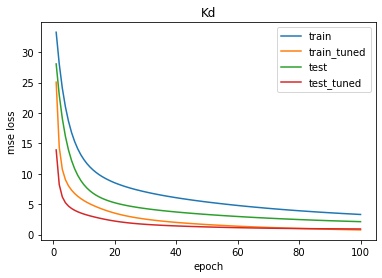

In [17]:
train_tuned_kd, test_tuned_kd, MAE_test_kd, MSE_test_kd = model_hyp(data_Kd, 'Kd', n_factors=bestParamDict_kd['n_factors'], 
                                                        bs=100, num_epochs=100, lr=bestParamDict_kd['learning_rate'])
plotting(train_losses_kd, test_losses_kd, train_tuned_kd, test_tuned_kd, title = 'Kd') 


## IC50 Dataset

In [18]:
bestParamDict_ic50 = grid_search(data_ic50, 'ic50', learning_rate=[0.05,0.04,0.03], n_factors=[20,50,80])

hyperparameters 1
The learning rate = 0.05
Number of factors = 20
MAE: 0.8152408600073012
MSE: 1.199767927875004
hyperparameters 2
The learning rate = 0.05
Number of factors = 50
MAE: 0.8099203689109866
MSE: 1.1883523094840724
hyperparameters 3
The learning rate = 0.05
Number of factors = 80
MAE: 0.8080587187156364
MSE: 1.1847756970652794
hyperparameters 4
The learning rate = 0.04
Number of factors = 20
MAE: 0.8326960429858643
MSE: 1.2348750541441789
hyperparameters 5
The learning rate = 0.04
Number of factors = 50
MAE: 0.8285938434264337
MSE: 1.228247503188113
hyperparameters 6
The learning rate = 0.04
Number of factors = 80
MAE: 0.8264884411346098
MSE: 1.2255676236428237
hyperparameters 7
The learning rate = 0.03
Number of factors = 20
MAE: 0.8735310659540519
MSE: 1.3296253451938436
hyperparameters 8
The learning rate = 0.03
Number of factors = 50
MAE: 0.8626468556269834
MSE: 1.3075614078327968
hyperparameters 9
The learning rate = 0.03
Number of factors = 80
MAE: 0.8584859028230816


### compare results

| num_epochs | learning_rate | n_factors | MAE | MSE 
|:-:|:-:|:-:|:-:|:-:|
| 100 | 0.05 | 20 | 0.815 | 1.199 |
| 100 | 0.05 | 50 | 0.509 | 1.188 |
| 100 | 0.05 | 80 | 0.808 | 1.184 |
| 100 | 0.04 | 20 | 0.832 | 1.234 |
| 100 | 0.04 | 50 | 0.828 | 1.228 |
| 100 | 0.04 | 80 | 0.826 | 1.225 |
| 100 | 0.03 | 20 | 0.873 | 1.329 |
| 100 | 0.03 | 50 | 0.862 | 1.307 |
| 100 | 0.03 | 80 | 0.858 | 1.298 |



epoch:  0  avg training loss:  16.728516373008436  avg test loss:  8.255310835975726
epoch:  20  avg training loss:  1.6717639065776662  avg test loss:  1.862377304887567
epoch:  40  avg training loss:  0.9161142297006863  avg test loss:  1.4615746198951796
epoch:  60  avg training loss:  0.5415068870591558  avg test loss:  1.2948664044179046
epoch:  80  avg training loss:  0.3621992944006119  avg test loss:  1.2211129769162121
MAE: 0.8086389562518336
MSE: 1.1852732920695477


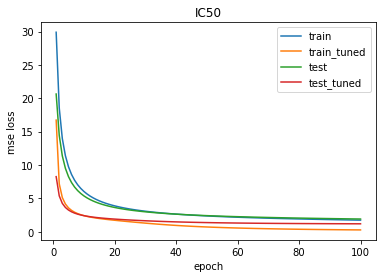

In [19]:
train_tuned_ic50, test_tuned_ic50, MAE_test_ic50, MSE_test_ic50 = model_hyp(data_ic50, 'ic50', n_factors=bestParamDict_ic50['n_factors'], 
                                                        bs=100, num_epochs=100, lr=bestParamDict_ic50['learning_rate'])
plotting(train_losses_ic50, test_losses_ic50, train_tuned_ic50, test_tuned_ic50, title = 'IC50') 


## Ki Dataset

In [20]:
bestParamDict_iki = grid_search(data_Ki, 'Ki', learning_rate=[0.05,0.04,0.03], n_factors=[20,50,80])

hyperparameters 1
The learning rate = 0.05
Number of factors = 20
MAE: 0.8451301811434262
MSE: 1.2761484988183374
hyperparameters 2
The learning rate = 0.05
Number of factors = 50
MAE: 0.8338658423659151
MSE: 1.2449440963941099
hyperparameters 3
The learning rate = 0.05
Number of factors = 80
MAE: 0.8309797740717654
MSE: 1.2372426130571899
hyperparameters 4
The learning rate = 0.04
Number of factors = 20
MAE: 0.868901145929371
MSE: 1.3360369422850857
hyperparameters 5
The learning rate = 0.04
Number of factors = 50
MAE: 0.8575869222980832
MSE: 1.307815804299884
hyperparameters 6
The learning rate = 0.04
Number of factors = 80
MAE: 0.8519859096717989
MSE: 1.2966000956726529
hyperparameters 7
The learning rate = 0.03
Number of factors = 20
MAE: 0.9166242619181283
MSE: 1.4599796784104835
hyperparameters 8
The learning rate = 0.03
Number of factors = 50
MAE: 0.9009264431262153
MSE: 1.4222735712296735
hyperparameters 9
The learning rate = 0.03
Number of factors = 80
MAE: 0.8956840802361469


### compare results

| num_epochs | learning_rate | n_factors | MAE | MSE 
|:-:|:-:|:-:|:-:|:-:|
| 100 | 0.05 | 20 | 0.845 | 1.276 |
| 100 | 0.05 | 50 | 0.833 | 1.244 |
| 100 | 0.05 | 80 | 0.830 | 1.237 |
| 100 | 0.04 | 20 | 0.868 | 1.336 |
| 100 | 0.04 | 50 | 0.857 | 1.307 |
| 100 | 0.04 | 80 | 0.851 | 1.296 |
| 100 | 0.03 | 20 | 0.916 | 1.459 |
| 100 | 0.03 | 20 | 0.901 | 1.422 |
| 100 | 0.03 | 50 | 0.895 | 1.413 |


epoch:  0  avg training loss:  21.184483693492027  avg test loss:  10.719505175847324
epoch:  20  avg training loss:  2.127403463567457  avg test loss:  2.214898727743487
epoch:  40  avg training loss:  1.0949460777010114  avg test loss:  1.6366911032848332
epoch:  60  avg training loss:  0.6325091868171662  avg test loss:  1.401989162855445
epoch:  80  avg training loss:  0.40219196903195537  avg test loss:  1.2962322427068254
MAE: 0.8334653527993775
MSE: 1.2441245982358216


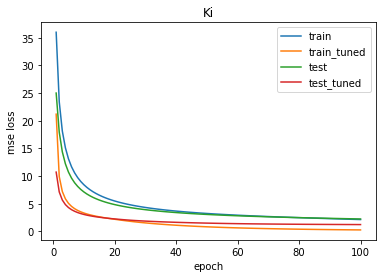

In [22]:
train_tuned_ki, test_tuned_ki, MAE_test_ki, MSE_test_ki = model_hyp(data_Ki, 'Ki', n_factors=bestParamDict_iki['n_factors'], 
                                                        bs=100, num_epochs=100, lr=bestParamDict_iki['learning_rate'])
plotting(train_losses_ki, test_losses_ki, train_tuned_ki, test_tuned_ki, title = 'Ki') 
